In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

y_0 = [0, 0, 1, 1, 1, 1]
x_n = 'ore_studiu'
x_0 = np.array([1, 3, 4, 5, 6, 8])
x_c = x_0 - x_0.mean()

with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    µ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(µ))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    idata_0 = pm.sample(1000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 1475 divergences after tuning. Increase `target_accept` or reparameterize.


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   4.701  2.504   0.365    9.380      0.080    0.058     992.0    1253.0   
β   5.255  2.019   1.448    8.561      0.068    0.048     878.0    1247.0   
bd -0.958  0.710  -1.850   -0.020      0.014    0.010    2108.0    1887.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0  


C:\Users\mihai\PycharmProjects\PMP-2024\venv\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


([<matplotlib.axis.XTick at 0x23e232ae150>,
 [Text(-4.0, 0, '0.5'),
  Text(-3.0, 0, '1.5'),
  Text(-2.0, 0, '2.5'),
  Text(-1.0, 0, '3.5'),
  Text(0.0, 0, '4.5'),
  Text(1.0, 0, '5.5'),
  Text(2.0, 0, '6.5'),
  Text(3.0, 0, '7.5'),
  Text(4.0, 0, '8.5')])

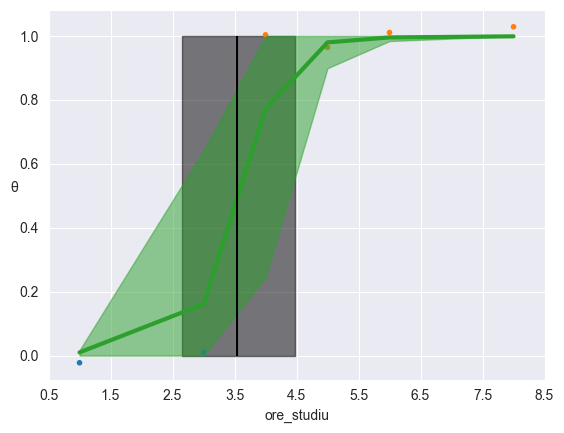

In [2]:
print(az.summary(idata_0, var_names=['α', 'β', 'bd']))

posterior_0 = idata_0.posterior.stack(samples=("chain", "draw"))
theta = posterior_0['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(posterior_0['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(x_c, np.random.normal(y_0, 0.02),
marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_0['θ'].T, color='C2', smooth=False)
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))



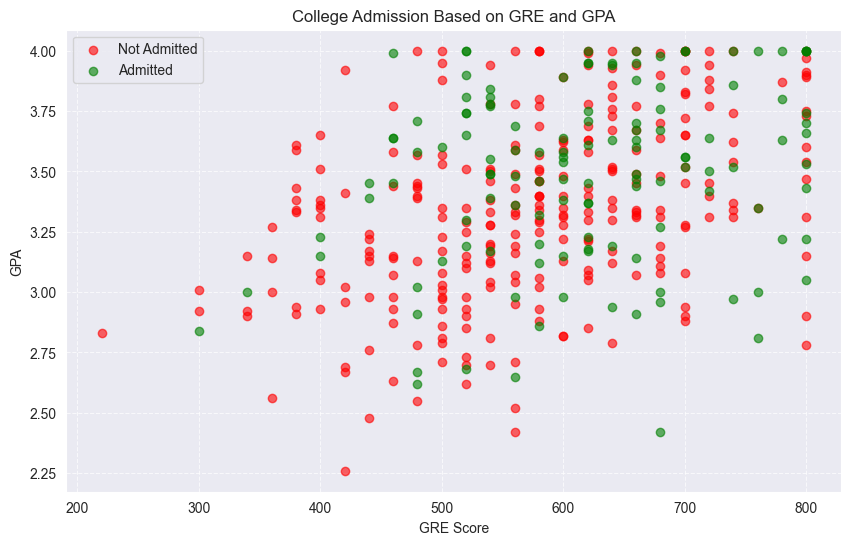

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('Admission.csv')

# Extract the data
X_gre = data['GRE'].values
X_gpa = data['GPA'].values
y = data['Admission'].values

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot points for not admitted (y=0) in red
plt.scatter(X_gre[y==0], X_gpa[y==0], color='red', label='Not Admitted', alpha=0.6)

# Plot points for admitted (y=1) in green
plt.scatter(X_gre[y==1], X_gpa[y==1], color='green', label='Admitted', alpha=0.6)

# Customize the plot
plt.xlabel('GRE Score')
plt.ylabel('GPA')
plt.title('College Admission Based on GRE and GPA')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


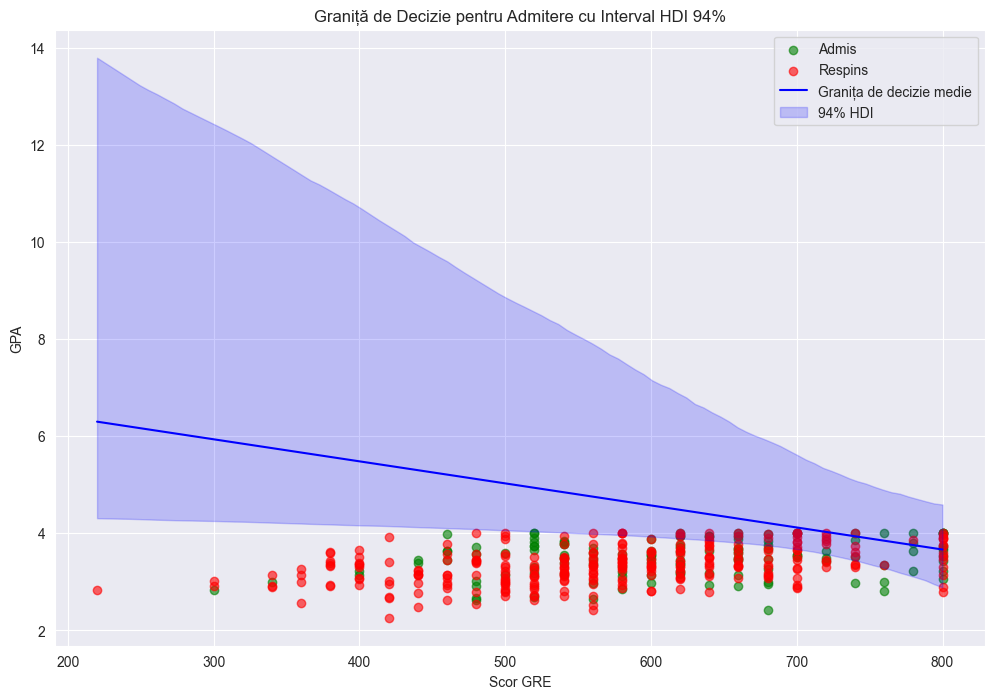


Rezultate pentru studentul 1 (GRE=550, GPA=3.5):
Probabilitate medie de admitere: 0.303
Interval HDI 90%: [0.260, 0.348]

Rezultate pentru studentul 2 (GRE=500, GPA=3.2):
Probabilitate medie de admitere: 0.232
Interval HDI 90%: [0.188, 0.281]


In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Citirea datelor
data = pd.read_csv('Admission.csv')
X_gre = data['GRE'].values
X_gpa = data['GPA'].values
y = data['Admission'].values

# Standardizarea predictorilor
X_gre_std = (X_gre - X_gre.mean()) / X_gre.std()
X_gpa_std = (X_gpa - X_gpa.mean()) / X_gpa.std()

# Construirea modelului Bayesian
with pm.Model() as model:
    # Distribuții a priori slab informative
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    
    # Calculul probabilității de admitere
    logit_p = beta0 + beta1 * X_gre_std + beta2 * X_gpa_std
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Funcție pentru calculul graniței de decizie
def calculate_decision_boundary(trace, X_gre_mean, X_gre_std, X_gpa_mean, X_gpa_std):
    beta0_samples = trace.posterior['beta0'].values.flatten()
    beta1_samples = trace.posterior['beta1'].values.flatten()
    beta2_samples = trace.posterior['beta2'].values.flatten()
    
    gre_range = np.linspace(X_gre.min(), X_gre.max(), 100)
    decision_boundaries = []
    
    for b0, b1, b2 in zip(beta0_samples, beta1_samples, beta2_samples):
        gpa_boundary = -(b0 + b1 * ((gre_range - X_gre_mean) / X_gre_std)) / b2
        gpa_boundary = gpa_boundary * X_gpa_std + X_gpa_mean
        decision_boundaries.append(gpa_boundary)
    
    mean_boundary = np.mean(decision_boundaries, axis=0)
    hdi_lower = np.percentile(decision_boundaries, 3, axis=0)
    hdi_upper = np.percentile(decision_boundaries, 97, axis=0)
    
    return gre_range, mean_boundary, hdi_lower, hdi_upper

# Calculul graniței de decizie și intervalului HDI
gre_range, mean_boundary, hdi_lower, hdi_upper = calculate_decision_boundary(
    trace, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

# Vizualizare
plt.figure(figsize=(12, 8))
plt.scatter(X_gre[y==1], X_gpa[y==1], c='green', label='Admis', alpha=0.6)
plt.scatter(X_gre[y==0], X_gpa[y==0], c='red', label='Respins', alpha=0.6)
plt.plot(gre_range, mean_boundary, 'b-', label='Granița de decizie medie')
plt.fill_between(gre_range, hdi_lower, hdi_upper, color='blue', alpha=0.2, label='94% HDI')
plt.xlabel('Scor GRE')
plt.ylabel('GPA')
plt.title('Graniță de Decizie pentru Admitere cu Interval HDI 94%')
plt.legend()
plt.grid(True)
plt.show()

# Funcție pentru calculul probabilității de admitere pentru un nou student
def calculate_admission_probability(trace, gre, gpa, X_gre_mean, X_gre_std, X_gpa_mean, X_gpa_std):
    gre_std = (gre - X_gre_mean) / X_gre_std
    gpa_std = (gpa - X_gpa_mean) / X_gpa_std
    
    beta0_samples = trace.posterior['beta0'].values.flatten()
    beta1_samples = trace.posterior['beta1'].values.flatten()
    beta2_samples = trace.posterior['beta2'].values.flatten()
    
    logit_p = beta0_samples + beta1_samples * gre_std + beta2_samples * gpa_std
    p_samples = 1 / (1 + np.exp(-logit_p))
    
    mean_prob = np.mean(p_samples)
    hdi_lower = np.percentile(p_samples, 5)
    hdi_upper = np.percentile(p_samples, 95)
    
    return mean_prob, hdi_lower, hdi_upper

# Calculul probabilității pentru primul student (GRE=550, GPA=3.5)
prob1, hdi_lower1, hdi_upper1 = calculate_admission_probability(
    trace, 550, 3.5, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

# Calculul probabilității pentru al doilea student (GRE=500, GPA=3.2)
prob2, hdi_lower2, hdi_upper2 = calculate_admission_probability(
    trace, 500, 3.2, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

print(f"\nRezultate pentru studentul 1 (GRE=550, GPA=3.5):")
print(f"Probabilitate medie de admitere: {prob1:.3f}")
print(f"Interval HDI 90%: [{hdi_lower1:.3f}, {hdi_upper1:.3f}]")

print(f"\nRezultate pentru studentul 2 (GRE=500, GPA=3.2):")
print(f"Probabilitate medie de admitere: {prob2:.3f}")
print(f"Interval HDI 90%: [{hdi_lower2:.3f}, {hdi_upper2:.3f}]")